### Image Loading and Preparations for Training ###
This notebook handles all image loading, such as resizing them to 100x100, creating buffers and batches, and setting autotune. It saves them into Tensorflow Datasets which can be directly imported for training.

Handles MAXAR Turkey Earthquake Marash dataset, used as the second unseen testing set.

In [15]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt


In [16]:
print(tf.__version__)

2.10.1


In [17]:
# set params
batch_size = 32
img_height = 100
img_width = 100
# data_dir = './islahiye_0207_building_crops/'
data_dir = './marash_building_crops/'
AUTOTUNE = tf.data.AUTOTUNE

In [18]:
# image_count = 10404 # islahiye
image_count = 40375 # marash
list_ds = tf.data.Dataset.list_files((data_dir + '*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [5]:
damaged_ds = tf.data.Dataset.list_files((data_dir + 'damaged/*'), shuffle=True, seed = 207)
l1 = len(damaged_ds)
print("Total number of available images in class 'damaged' is:", l1)
undamaged_ds = tf.data.Dataset.list_files((data_dir + 'undamaged/*'), shuffle=True, seed = 207)
l2 = len(undamaged_ds)
print("Total number of available images in class 'undamaged' is:", l2)
print("Total number of available images is:", image_count)

Total number of available images in class 'damaged' is: 3005
Total number of available images in class 'undamaged' is: 37370
Total number of available images is: 40375


In [6]:
# undamaged_ds = undamaged_ds.shuffle(l1, seed = 207).take(l1)
# image_count = l1*2
# list_ds = undamaged_ds.concatenate(damaged_ds)
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
# # print("Total number of combined images after undersampling majority class is:", len(list_ds))

In [7]:
# Take x1 each of damaged and undamaged examples as training ds
x1 = 200
damaged_ds_train = damaged_ds.take(x1)
undamaged_ds_train = undamaged_ds.take(x1)
train_ds = undamaged_ds_train.concatenate(damaged_ds_train).shuffle(2*x1, reshuffle_each_iteration=False)

# Take x2 each of damaged and undamaged examples as validation ds
x2 = 1
damaged_ds_val = damaged_ds.skip(x1).take(x2)
undamaged_ds_val = undamaged_ds.skip(x1).take(x2)
val_ds = undamaged_ds_val.concatenate(damaged_ds_val).shuffle(2*x2, reshuffle_each_iteration=False)

# Merge the rest into a test ds
damaged_ds_test = damaged_ds.skip(x1+x2)
undamaged_ds_test = undamaged_ds.skip(x1+x2)
test_ds = undamaged_ds_test.concatenate(damaged_ds_test).shuffle(image_count-2*x1-2*x2, reshuffle_each_iteration=False)

print("Total number of images for testing is:", len(test_ds))

Total number of images for testing is: 39973


In [8]:
for f in list_ds.take(10):
    print(f.numpy())

b'.\\marash_building_crops\\undamaged\\marash-38532-undamaged.png'
b'.\\marash_building_crops\\undamaged\\marash-35915-undamaged.png'
b'.\\marash_building_crops\\undamaged\\marash-24647-undamaged.png'
b'.\\marash_building_crops\\damaged\\marash-5797-damaged.png'
b'.\\marash_building_crops\\undamaged\\marash-38360-undamaged.png'
b'.\\marash_building_crops\\undamaged\\marash-19423-undamaged.png'
b'.\\marash_building_crops\\undamaged\\marash-23565-undamaged.png'
b'.\\marash_building_crops\\damaged\\marash-21668-damaged.png'
b'.\\marash_building_crops\\undamaged\\marash-8882-undamaged.png'
b'.\\marash_building_crops\\undamaged\\marash-32918-undamaged.png'


In [9]:
class_names = np.array(sorted([item for item in os.listdir(data_dir)],reverse=True))
print(class_names)

['undamaged' 'damaged']


In [10]:
# tensorflow tutorial functions for manual creation of datasets
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    # (FORMAT = PNG) convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size (WITH PAD)
    return tf.image.resize_with_pad(img, 100, 100)

def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def configure_for_testing(ds):
    ds = ds.cache()
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [11]:
# use this cell to split dataset into train, val, and test
val_size = int(image_count * 0.1)
test_size = int(image_count * 0.1)

train_ds = list_ds.skip(val_size + test_size)
val_ds = list_ds.take(val_size + test_size)

test_ds = val_ds.take(test_size)
val_ds = val_ds.skip(test_size)

In [12]:
# use this cell to generate a very small training set
training_size = 2000

train_ds = list_ds.skip(training_size).take(training_size)
val_ds = list_ds.take(training_size)

In [19]:
# use this cell to generate a regular training set and val set using all data
val_size = int(image_count * 0.1)

train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [ ]:
# use this cell to save the rest as a test set
test_ds = list_ds.skip(training_size*2)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_ds = configure_for_testing(test_ds)

In [20]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [12]:
# # use this cell to make all images for testing purposes only
# test_ds = list_ds
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_ds = configure_for_testing(test_ds)

In [32]:
for image, label in test_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (32, 100, 100, 3)
Label:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


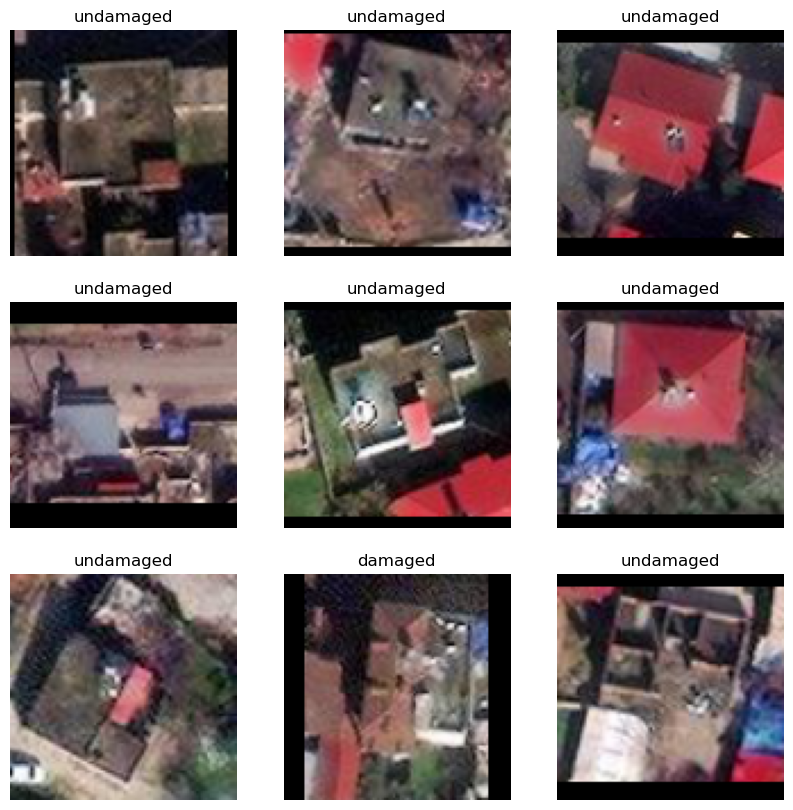

In [61]:
image_batch, label_batch = next(iter(test_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [21]:
# save the datasets
train_ds.save('turkey/train_m_3')
val_ds.save('turkey/val_m_3')

In [14]:
test_ds.save('turkey/test_m_1')